# CIFAR10 분류기

CIFAR-10은 사용 가능한 몇 가지 균형 잡힌 데이터 세트 중 하나다. Canadian Institute for Advanced Research)에서 만들었고 규모도 상당히 크다. 이 데이터 세트는 데이터가 겹치지 않게 10개 범주에 균일한 분포로 들어 있다는 큰 장점이 있다. 이미지는 해상도가 낮고 상당히 작아서 적은 메모리 시스템만으로도 충분히 훈련할 수 있는 데이터 세트다. CIFAR-10을 분류기를 준비해 복잡하고 깊은 CNN(Convolutional Neural Network)에 사용해 보자.



In [1]:
%matplotlib inline

ModuleNotFoundError: No module named 'matplotlib'

In [1]:
# import required libs
import tensorflow.keras
import numpy as np
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D,BatchNormalization

import cnn_utils as utils

import matplotlib.pyplot as plt
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}

plt.rcParams.update(params)
np.random.seed(42)

2024-05-13 10:44:24.324984: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-13 10:44:25.114389: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-13 10:44:28.675612: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdirectml.d6f03b303ac3c4f2eeb8ca631688c9757b361310.so
2024-05-13 10:44:28.675751: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdxcore.so
2024-05-13 10:44:28.692774: I tensorflow/c/logging.cc:34] Successfully opened dynamic l

In [2]:
import tensorflow as tf
tf.__version__

'2.10.0'

파라미터 세팅

In [3]:
BATCH_SIZE = 128
NUM_CLASSES = 10
EPOCHS = 25
INPUT_SHAPE = (32, 32, 3)
WEIGHT_DECAY = 1e-4
KFOLD_WEIGHT_PATH=r'./model/cnn_cifar10_weights_{epoch:02d}_.hdf5'

In [4]:
label_dict = {0:'airplane',
             1:'automobile',
             2:'bird',
             3:'cat',
             4:'deer',
             5:'dog',
             6:'frog',
             7:'horse',
             8:'ship',
             9:'truck'}

# for evaluation
TOP_N = 1

## CIFAR10 데이터 세트 로딩

CIFAR10 데이터 세트는 케라스에서 load_data() API를 통해 로딩할 수 있다. 타깃 레이블을 통해 훈련과 테스트 데이트로 구분한다.

원본 영상은 0부터 255까지의 RGB 계수로 구성되어 있으므로 데이터를 다운로드하여  1/255로 스케일링하여 0과 1로 변환한다.

In [5]:
# 데이터를 섞어서 훈련과 테스트 데이터로 분리한다.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [6]:
x_train = x_train/255.
x_test = x_test/255.

## 데이터 세트 상세

데이터 세트는 총 60,000개의 샘플과 50k의 훈련 데이터 세트로 구성되며 있으며 나머지는 테스트 데이터 세트다.

In [7]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [8]:
# 클래스 벡터를 이진 클래스 매트릭스로 변환
y_train = tensorflow.keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = tensorflow.keras.utils.to_categorical(y_test, NUM_CLASSES)

## CNN 기반의 심층 신경망 구축

```케라스```로 convolution, 최대 풀링, 배치 정규화, 평탄화, 밀집층이 있는 간단한 CNN을 준비한다. 드롭아웃으로 모델이 과대적합되지 않도록 한다.

In [12]:
model = Sequential()
model.add(Conv2D(16, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=INPUT_SHAPE))

model.add(Conv2D(32, (3,3), padding='same', 
                kernel_regularizer=regularizers.l2(WEIGHT_DECAY),
                activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES, activation='softmax'))

## 네트워크 아키텍처 시각화

In [13]:
from IPython.display import SVG
from tensorflow.python.keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True, 
                 show_layer_names=True, rankdir='TB').create(prog='dot', format='svg'))

ImportError: cannot import name 'wrappers' from 'tensorflow.python.keras.layers' (/root/workspace/tmp/venv/lib/python3.10/site-packages/tensorflow/python/keras/layers/__init__.py)

In [42]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 30, 30, 16)        448       
                                                                 
 conv2d_5 (Conv2D)           (None, 30, 30, 32)        4640      
                                                                 
 batch_normalization_2 (Batc  (None, 30, 30, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 15, 15, 32)        0         
                                                                 
 flatten_2 (Flatten)         (None, 7200)             

## 모델 컴파일

In [14]:
model.compile(loss=tensorflow.keras.losses.categorical_crossentropy,
              optimizer=tensorflow.keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [15]:
early_stop_callback = [EarlyStopping(monitor='val_loss', 
                                     patience=3, verbose=0),
                       ModelCheckpoint(KFOLD_WEIGHT_PATH, 
                                       monitor='val_loss', 
                                       save_best_only=True, 
                                       verbose=0),
                      ]

## 분류기 훈련

In [16]:
history = model.fit(x_train, y_train,
                    validation_split=0.1,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    verbose=1,
                    callbacks=early_stop_callback,)

Epoch 1/25


2024-05-13 10:45:53.535174: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-13 10:45:53.629100: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-13 10:45:53.629181: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 1, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-13 10:45:53.629207: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 8477 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2024-05-13 10:45:53.629225: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_fa

352/352 [==============================] - ETA: 0s - loss: 3.1537 - accuracy: 0.1080

2024-05-13 10:46:10.595217: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-13 10:46:10.629094: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-13 10:46:10.629178: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 1, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-13 10:46:10.629218: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 8477 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2024-05-13 10:46:10.629235: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_fa

352/352 [==============================] - 18s 34ms/step - loss: 3.1537 - accuracy: 0.1080 - val_loss: 2.2877 - val_accuracy: 0.1414
Epoch 2/25
352/352 [==============================] - 9s 26ms/step - loss: 2.7658 - accuracy: 0.1275 - val_loss: 2.2384 - val_accuracy: 0.1808
Epoch 3/25
352/352 [==============================] - 9s 26ms/step - loss: 2.5818 - accuracy: 0.1477 - val_loss: 2.1715 - val_accuracy: 0.2126
Epoch 4/25
352/352 [==============================] - 9s 25ms/step - loss: 2.4588 - accuracy: 0.1658 - val_loss: 2.1210 - val_accuracy: 0.2370
Epoch 5/25
352/352 [==============================] - 10s 28ms/step - loss: 2.3655 - accuracy: 0.1817 - val_loss: 2.0829 - val_accuracy: 0.2558
Epoch 6/25
352/352 [==============================] - 10s 27ms/step - loss: 2.3120 - accuracy: 0.1917 - val_loss: 2.0522 - val_accuracy: 0.2736
Epoch 7/25
352/352 [==============================] - 10s 28ms/step - loss: 2.2633 - accuracy: 0.2056 - val_loss: 2.0267 - val_accuracy: 0.2872
Epoch 

In [15]:
#model.save(filepath=r'../model/cnn_cifar10.h5')

## 모델 성능 예측과 테스트

In [17]:
score = model.evaluate(x_test, y_test, verbose=1)

313/313 [==============================] - 3s 8ms/step - loss: 1.7666 - accuracy: 0.3930


In [18]:
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.766569972038269
Test accuracy: 0.3930000066757202


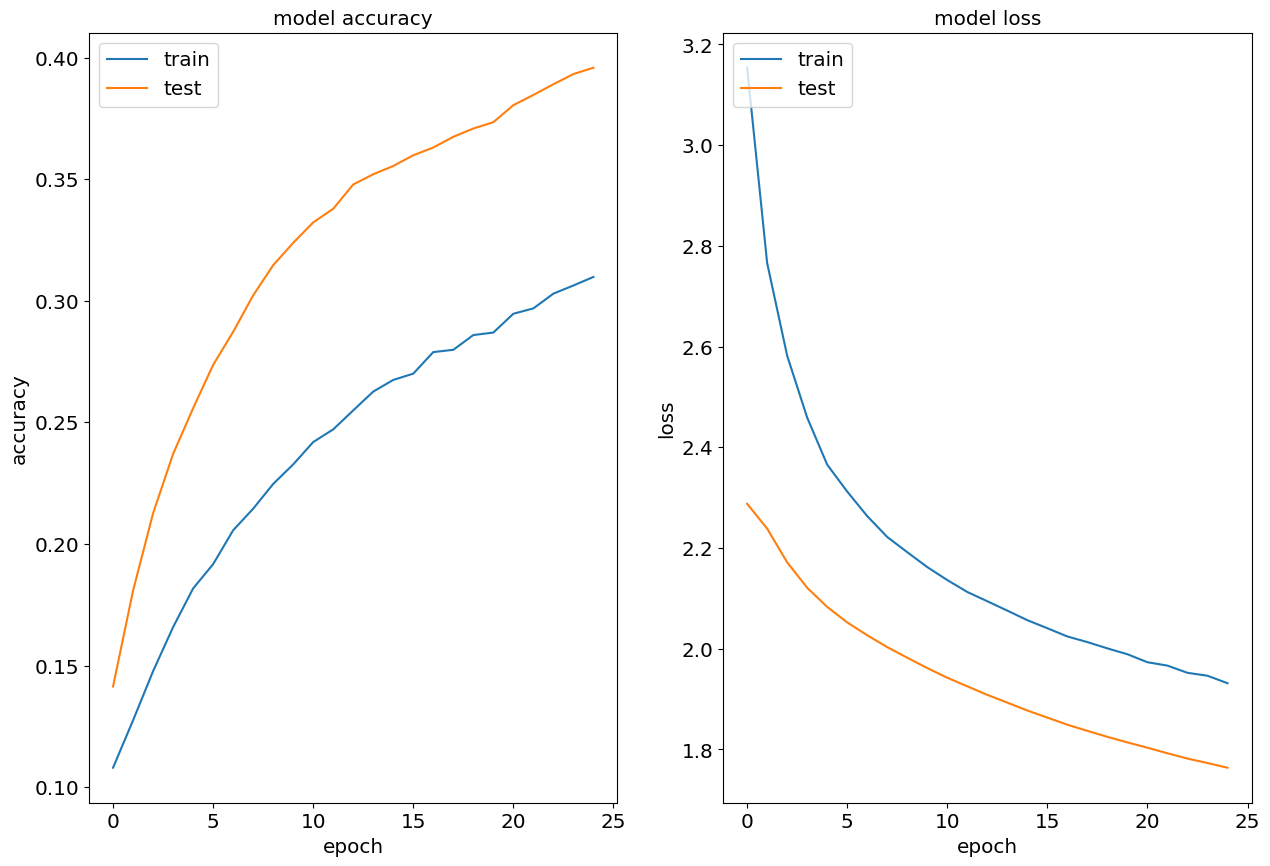

In [21]:
plt.figure(1,figsize=(15,10))  

# summarize history for accuracy  

plt.subplot(121)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  

# summarize history for loss  

plt.subplot(122)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()  

Though the model performance is commendable, there are signs of overfitting. 
The test loss starts increasing after a few epochs along with flattening of the test accuracy

# CNN이 이미지를 분류하는 방법


RuntimeError: The layer sequential_1 has never been called and thus has no defined input shape.

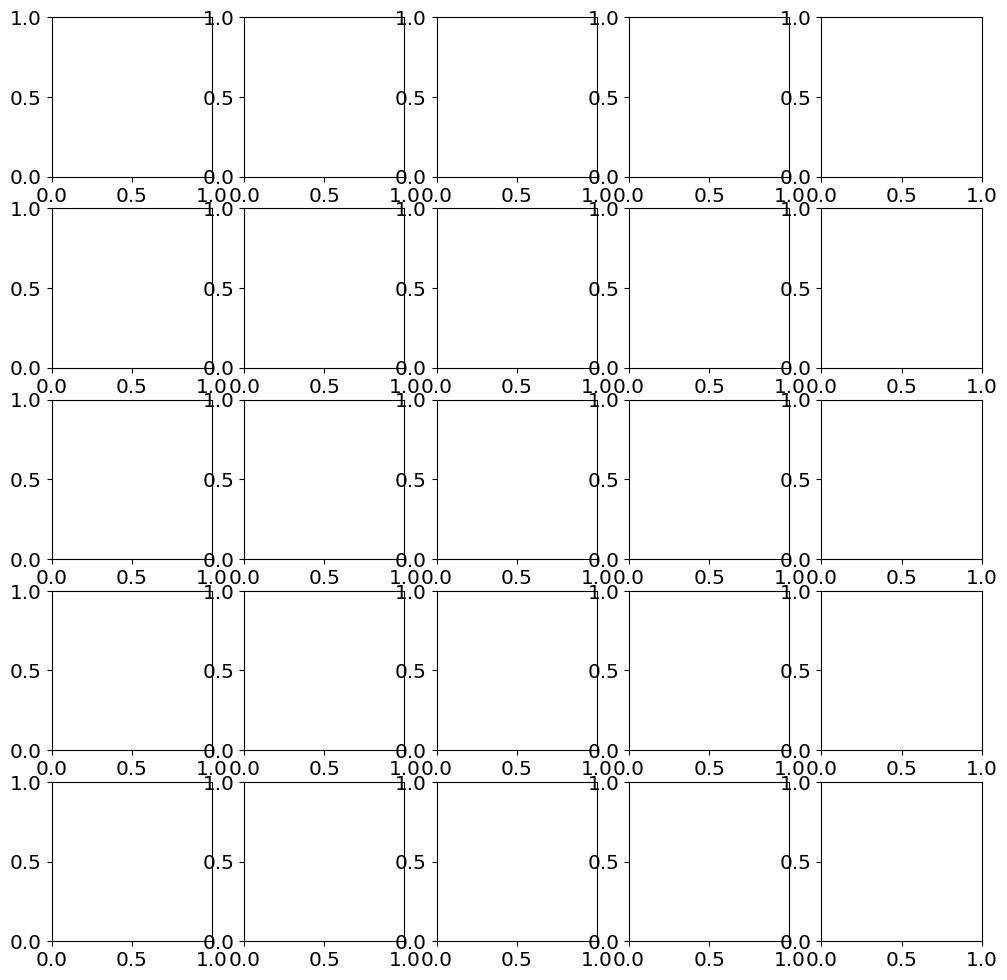

In [22]:
utils.plot_predictions(model=model,dataset=x_test,
                       dataset_labels=y_test,
                       label_dict=label_dict,
                       batch_size=25,
                       grid_height=5,
                       grid_width=5)

## CNN을 이해하기 위한 유틸러티 방법
+ source: https://github.com/fchollet/keras/issues/431
+ source: https://github.com/philipperemy/keras-visualize-activations/blob/master/read_activations.py

In [20]:
test_image_idx = 1005

In [21]:
activations = utils.get_activations(model, x_test[test_image_idx].reshape(1,32,32,3))

----- activations -----
(1, 30, 30, 16)
(1, 30, 30, 32)
(1, 30, 30, 32)
(1, 15, 15, 32)
(1, 15, 15, 32)
(1, 7200)
(1, 128)
(1, 128)
(1, 10)


Displaying activation map 0


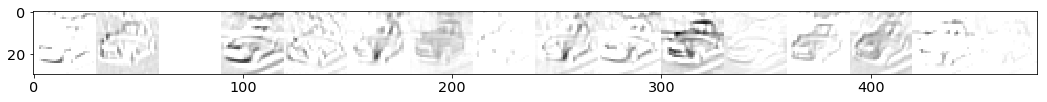

Displaying activation map 1


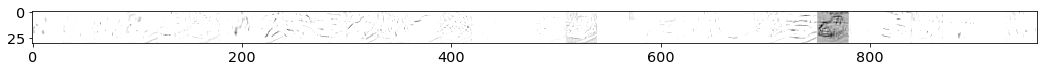

Displaying activation map 2


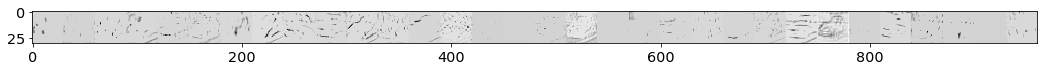

Displaying activation map 3


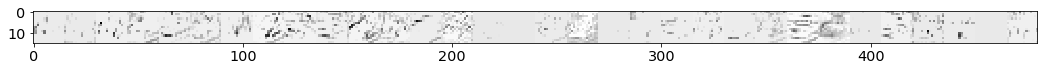

Displaying activation map 4


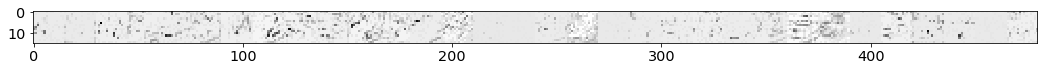

Displaying activation map 5


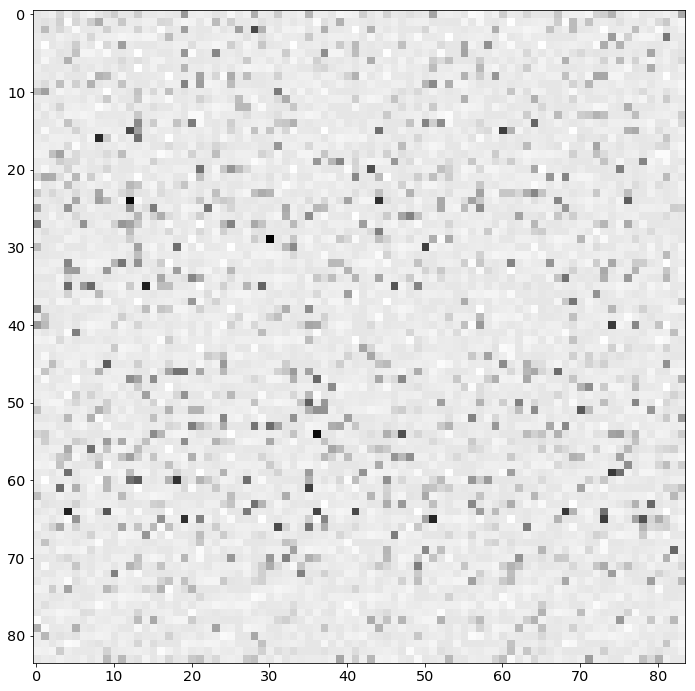

Displaying activation map 6


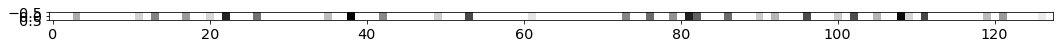

Displaying activation map 7


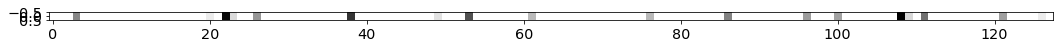

Displaying activation map 8


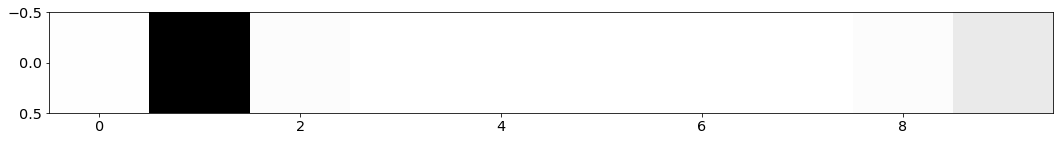

In [22]:
utils.display_activations(activations)

In [23]:
pred_label = label_dict.get(model.predict_classes(x_test[test_image_idx].reshape(1,32,32,3)).argmax())
actual_label = label_dict.get(y_test[test_image_idx].argmax())

In [24]:
print('Actual Label={}\nPredicted Label={}'.format(actual_label,pred_label))

Actual Label=automobile
Predicted Label=airplane
